In [1]:
import numpy as np
import scipy 

import qiskit
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.circuit import ParameterVector, Parameter
from qiskit import algorithms
from qiskit.ignis.verification.tomography import state_tomography_circuits, TomographyFitter, StateTomographyFitter
from qiskit.quantum_info import Statevector, state_fidelity
from qiskit.opflow import I, X, Y, Z
from qiskit.quantum_info.operators import Operator
from qiskit.algorithms.optimizers import SPSA

from qiskit import IBMQ, transpile
from qiskit.providers.aer import AerSimulator

from qiskit.test.mock import FakeGuadalupe

from qiskit_ionq import IonQProvider

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd

In [2]:
IBMQ.load_account() # Load account from disk
IBMQ.providers()    # List all available providers

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-community', group='qhack-hackathon', project='7-qubit')>,
 <AccountProvider for IBMQ(hub='ibm-q-community', group='qhack-hackathon', project='16-qubit')>]

## Table of contents
- [Experiment 1: Two qubits, one layer](#exp1)
- [Experiment 2: Three qubits, two layers](#exp2)
- [Experiment 3: Generalization](#exp3)
- [Experiment 4: Model capacity](#exp4)

# Simulating collective neutrino oscillation using QAOA algorithm 

As stated in the readme, our project aim is to demonstrate the time and space evolution of the set of amplitudes from a Schrodinger equation:

\begin{equation}
|\phi(t)\rangle=e^{-iHt}|\phi_{0}\rangle
\end{equation}

The Hamiltonian from the equation is the Hamiltonian for neutrino flavor evolution in an environment with high denisty of neutrinos which inlcude vacuum and forward-scattering interaction contributions. Let have a closer look into this Hamiltonian

The Hamiltonian that characterizes the system of $N$ interacting neutrinos (each represented by a qubit) is given by
\begin{equation}
H = \sum_{k=1}^N \overrightarrow{b} \cdot \overrightarrow{\sigma_k} + \sum_{p<q}^N J_{pq} \overrightarrow{\sigma_p} \cdot \overrightarrow{\sigma_q}
\end{equation}
with the external field $\overrightarrow{b} = (b^x,b^y,b^z) = \left(\sqrt{1-0.925^2}, 0, -0.925\right)$ and the pair coupling matrix $J_{pq} = 1 - \cos(\theta_{pq})$, where $\theta_{pq} = \arccos(0.9) \frac{|p-q|}{N-1}$.

We choose to trotterize $H$ by viewing it in the form of $H = A_1 + A_2 + A_3 + B_1 + B_2 + B_3$, where
\begin{align}
A_1 &= \sum_{k=1}^N b^x \sigma_k^x, 
&A_2 &= \sum_{k=1}^N b^y \sigma_k^y, 
&A_3 &= \sum_{k=1}^N b^z \sigma_k^z, \\
B_1 &= \sum_{p<q}^N J_{pq} \sigma_p^x \sigma_q^x, 
&B_2 &= \sum_{p<q}^N J_{pq} \sigma_p^y \sigma_q^y, 
&B_3 &= \sum_{p<q}^N J_{pq} \sigma_p^z \sigma_q^z.
\end{align}

The time evolution can be approximated by
\begin{align}
e^{-iHt} &\approx (e^{-iA_1t/n}e^{-iA_2t/n}e^{-iA_3t/n}e^{-iB_1t/n}e^{-iB_2t/n}e^{-iB_3t/n})^n \\
&= \prod_{i=1}^n e^{-iA_1t/n}e^{-iA_2t/n}e^{-iA_3t/n}e^{-iB_1t/n}e^{-iB_2t/n}e^{-iB_3t/n}
\end{align}
We introduce parameters $\boldsymbol{\alpha},\boldsymbol{\beta},\boldsymbol{\gamma}, \boldsymbol{\delta}, \boldsymbol{\epsilon}, \boldsymbol{\kappa} \in \mathbb{R}^n$ and trotterize the unitary operator as follows
\begin{align}
e^{-iHt} &= \prod_{i=1}^n e^{-iA_1\alpha_i t}e^{-iA_2\beta_i t}e^{-iA_3\gamma_i t}e^{-iB_1 \delta_i t}e^{-iB_2 \epsilon_i t}e^{-iB_3 \kappa_i t} \end{align}
Let's see how to implement these components. We show that the first term can be written as a product of rotations about the $x$-axis.
\begin{align}
e^{-iA_1\alpha_i t} &= e^{-i\alpha_i t\sum_{k=1}^N b^x \sigma_k^x} \\
&\equiv e^{-i\alpha_i t\sum_{k=1}^N \sigma_k^x} \\ 
&= \prod_{k=1}^N e^{-i\alpha_i t \sigma_k^x} \\
&= \prod_{k=1}^N \text{RX}_k(2\alpha_i t)
\end{align}
In the second line, $b^x$ has been absorbed into the learnable parameters $\alpha_i$. Moreover, the term can be written as a product of smaller exponential terms as in the third line because $\sigma_x$'s commute with each other. This is due to the fact that $[A,B] \equiv AB-BA = 0$ implies $e^A = e^B$. Similarly,
\begin{align}
e^{-iA_2\beta_i t} &= \prod_{k=1}^N \text{RY}_k(2\beta_i t) \\ 
e^{-iA_3\gamma_i t} &= \prod_{k=1}^N \text{RZ}_k(2\gamma_i t) 
\end{align}

The same derivation can be made for two-qubit interactions. In particular,
\begin{align}
e^{-iB_1\delta_i} &= \prod_{p<q}^N e^{-i\delta_i J_{pq} \sigma_p^x \sigma_q^x} \\
&= \prod_{p<q}^N \text{RXX}_k(2 J_{pq} \delta_i t) \\
e^{-iB_2\epsilon_i} &= \prod_{p<q}^N \text{RYY}_k(2 J_{pq} \epsilon_i t) \\
e^{-iB_3\kappa_i} &= \prod_{p<q}^N \text{RZZ}_k(2 J_{pq} \kappa_i t)
\end{align}

With the decomposition, the time evolution be can approximated by a sequence of single- and two-qubit rotation gates. The sequence of those gates contains $6n+1$ parameters, $6n$ out of which are learnables, and the other is the time elapsed of the evolution.

In [3]:
def circuit(num_qubits:int, num_layers:int):
    """
    Construct the variational form
    """
    varform = QuantumCircuit(num_qubits)

    t = Parameter('t')
    alpha = ParameterVector('alpha', num_layers)
    beta = ParameterVector('beta', num_layers)
    gamma = ParameterVector('gamma', num_layers)

    delta = ParameterVector('delta', num_layers)
    eps = ParameterVector('eps', num_layers)
    kappa = ParameterVector('kappa', num_layers)

    const = np.arccos(0.9)
    angles = np.zeros((num_qubits,num_qubits))
    for p in range(num_qubits):
        for q in range(num_qubits):
            angles[p,q] = const * abs(p-q) / (num_qubits-1)
    J = 1 - np.cos(angles) 

    for n in range(num_layers):
        for k in range(num_qubits):
            varform.rx(2*alpha[n]*t, k)
        for k in range(num_qubits):
            varform.ry(2*beta[n]*t, k)
        for k in range(num_qubits):
            varform.rz(2*gamma[n]*t, k)

        ## 2-body interactions
        for p in range(num_qubits):
            for q in range(num_qubits):
                if p < q:
                    varform.rxx(2*delta[n]*J[p,q]*t, p, q)

        for p in range(num_qubits):
            for q in range(num_qubits):
                if p < q:
                    varform.ryy(2*eps[n]*J[p,q]*t, p, q)

        for p in range(num_qubits):
            for q in range(num_qubits):
                if p < q:
                    varform.rzz(2*kappa[n]*J[p,q]*t, p, q)
        varform.barrier()

    return varform, t

In [4]:
varform, time_param = circuit(num_qubits=2, num_layers=1)

In [5]:
print(varform.num_parameters)
print(varform.parameters)
print(varform.draw())

7
ParameterView([ParameterVectorElement(alpha[0]), ParameterVectorElement(beta[0]), ParameterVectorElement(delta[0]), ParameterVectorElement(eps[0]), ParameterVectorElement(gamma[0]), ParameterVectorElement(kappa[0]), Parameter(t)])
     ┌──────────────────┐┌─────────────────┐┌──────────────────┐»
q_0: ┤ Rx(2*alpha[0]*t) ├┤ Ry(2*beta[0]*t) ├┤ Rz(2*gamma[0]*t) ├»
     ├──────────────────┤├─────────────────┤├──────────────────┤»
q_1: ┤ Rx(2*alpha[0]*t) ├┤ Ry(2*beta[0]*t) ├┤ Rz(2*gamma[0]*t) ├»
     └──────────────────┘└─────────────────┘└──────────────────┘»
«     ┌──────────────────────┐┌────────────────────┐                      ░ 
«q_0: ┤0                     ├┤0                   ├─■────────────────────░─
«     │  Rxx(0.2*delta[0]*t) ││  Ryy(0.2*eps[0]*t) │ │ZZ(0.2*kappa[0]*t)  ░ 
«q_1: ┤1                     ├┤1                   ├─■────────────────────░─
«     └──────────────────────┘└────────────────────┘                      ░ 


To avoid confusion, denote the unitary obtained by the variational form is $U(\boldsymbol{\theta},t)$, where $\boldsymbol{\theta}$ represent all learnable parameters, in constrast to the true time evolution $e^{-iHt}$. Our goal is to simulate $e^{-iHt}$ over a period of time. We choose the following objective function to capture the consistency in the capability of $U(\boldsymbol{\theta},t)$ to approximate $e^{-iHt}$.
\begin{align}
\max_\boldsymbol{\theta} & f(\boldsymbol{\theta}), & \text{where } & f(\boldsymbol{\theta}) = \int_0^T \left| \langle 0|e^{iHt} U(\boldsymbol{\theta},t) |0\rangle \right|^2 dt
\end{align}
The function is averaged fidelity between the ideal final states and the final states obtain by $U(\boldsymbol{\theta},t)$. We observe through experiments that the variational form has relatively good generalization capability, thus a small number of time marks suffices. In practice, running quantum circuits on a real device outputs a statistic of measurement results. It is possible to reconstruct the density matrix $\rho(\boldsymbol{\theta},t)$ of the final state by apping state tomography. The optimization problem we actually solve is
\begin{align}
\max_\boldsymbol{\theta} & \frac{1}{S} \sum_{s=1}^S \left| \langle 0|e^{iHt_s} U(\boldsymbol{\theta},t_s) |0\rangle \right|^2, & \text{for statevector simulator, or} \\
\max_\boldsymbol{\theta} & \frac{1}{S} \sum_{s=1}^S \left| \langle 0|e^{iHt_s} \rho(\boldsymbol{\theta},t_s) e^{-iHt_s} |0\rangle \right|^2, & \text{for physical devices.}
\end{align}
for a set of evenly spaced time marks $\{t_s\}_{s=1}^S$ from $0$ to $T$.

In [6]:
def exact_hamiltonian(num_qubits:int):
    """
    Compute the exact Hamiltonian
    """
    
    def pair_coupling_matrix():
        J = np.zeros(shape=(num_qubits, num_qubits))
        for p in range(num_qubits):
            for q in range(num_qubits):
                J[p,q] = 1 - np.cos(np.arccos(0.9)*(np.abs(p-q)/(num_qubits-1)))
        return J
    

    def sigma_k(k):
        sigma_X = ( (I^k) ^ X ^ (I^(num_qubits-k-1)) ).to_matrix()
        sigma_Y = ( (I^k) ^ Y ^ (I^(num_qubits-k-1)) ).to_matrix()
        sigma_Z = ( (I^k) ^ Z ^ (I^(num_qubits-k-1)) ).to_matrix()
        return np.array([sigma_X, sigma_Y, sigma_Z])

    dim = 2**num_qubits

    b_vector = np.array([np.sqrt(1.0-0.925**2), 0.0, -0.925])
    sigma_vectors = [sigma_k(qubit) for qubit in range(num_qubits)] # num_qubits x 3 x (dim x dim)
    J = pair_coupling_matrix()

    first_term = np.zeros(shape=(dim,dim), dtype=np.complex128)
    for i in range(num_qubits):
        sigma_vec_mul = (b_vector[:, None, None] * sigma_vectors[i])
        first_term += np.sum(sigma_vec_mul, axis=0)

    second_term = np.zeros(shape=(dim,dim), dtype=np.complex128)
    for p in range(num_qubits):
        for q in range(num_qubits):
            if p < q:
                for pauli_idx in range(3):
                    second_term += J[p,q] * (sigma_vectors[p][pauli_idx] @ sigma_vectors[q][pauli_idx])

    return first_term + second_term  

In [7]:
def exact_unitaries(num_qubits:int, ts:np.ndarray):
    """
    Compute the exact unitary operators exp(-iHt) for various t
    """
    H = exact_hamiltonian(num_qubits)
    operators = []
    for t in ts:
        U = scipy.linalg.expm(-1j * t * H)
        operators.append(Operator(U))
        #print(operators[-1].is_unitary())
    return operators

def exact_states(num_qubits:int, ts:np.ndarray , init_state:Statevector=None):
    """
    Compute the exact output states by applying exp(-iHt) on an initial state for various t
    """
    init_state = init_state or Statevector.from_label('0'*num_qubits)

    unitaries = exact_unitaries(num_qubits, ts)

    output_states = [init_state.evolve(U) for U in unitaries]
    return output_states

We perform training experiments with both noiseless (Qiskit Statevector) simulator and noisy simulators. Due to high traffic, it is not possible to use IBM and IonQ's hardwares and online simulators as the optimization routine requires many queries to the cost function which involves running quantum circuits. Instead, the use FakeGuadalupe as our noisy simulator. The optimization algorithm is BFGS for noiseless and SPSA for noisy simulations.

In [8]:
def optimize_simulation(varform:QuantumCircuit, time_param:float, num_time_marks:int, 
                        time_max:float=1., noisy_backend:bool=False, verbose=False):

    def cost_fn(x):
        full_circuits = [circ.bind_parameters(x) for circ in bind_circuits]
    
        if noisy_backend:
            tomo_states = []
            for circ in full_circuits:
                qst = state_tomography_circuits(circ, circ.qubits)
                job_res = qiskit.execute(qst, backend, shots=512).result()
                #job_res = [qiskit.execute(circ, backend, shots=512).result() for circ in qst]
               
                #job_res = meas_filter.apply(job_res) # apply measurement error mitigation
                tomo_fitter = StateTomographyFitter(job_res, qst)
                rho_fit = tomo_fitter.fit(method='lstsq')
                tomo_states.append(rho_fit)

            fids = []
            for i in range(len(tomo_states)):
                fids.append(state_fidelity(tomo_states[i], ideal_states[i]))
            sum_fid = sum(fids)

            if verbose:
                print("Fidelity sum: ", sum_fid)
            return -sum_fid / len(tomo_states)

        else: # noiseless backend
            circuit_states = [init_state.evolve(full_circ) for full_circ in full_circuits]
            fids = []
            for i in range(len(circuit_states)):
                fids.append(state_fidelity(circuit_states[i], ideal_states[i]))
            sum_fid = sum(fids)
            
            if verbose:
                print("Fidelity sum: ", sum_fid)
                
            return -sum_fid / len(circuit_states)

        
    if noisy_backend:
        backend = FakeGuadalupe()
        #backend = IonQProvider().get_backend("ionq_simulator")
#     else:
#         backend = Aer.get_backend('qasm_simulator')

    start = 0.
    end = time_max
    ts = np.linspace(end,start,num_time_marks, endpoint=False)[::-1]
    if verbose:
        print("Time marks used: ", ts)
    bind_circuits = [varform.bind_parameters({time_param: t}) for t in ts]
    init_state = Statevector.from_label('0'*varform.num_qubits)
    ideal_states = exact_states(varform.num_qubits, ts, init_state)
    
    
    if noisy_backend:
        init_params = np.random.rand(varform.num_parameters-1)
        opt = SPSA(maxiter=500)
        point, value, nfev = opt.optimize(num_vars=varform.num_parameters-1, objective_function=cost_fn,initial_point= init_params)
        return point, value
        
    else:
        init_params = np.random.rand(varform.num_parameters-1)
        options = {'disp':True}
        res = scipy.optimize.minimize(cost_fn, x0=init_params, method='BFGS', tol=10e-4, options=options)
        return res.x, res.fun

In [9]:
def simulation(varform, param, ts):
    init_state = Statevector.from_label('0'*varform.num_qubits)
    ideal_states = exact_states(varform.num_qubits, ts, init_state)

    bind_circuits = [varform.bind_parameters({time_param: t}) for t in ts]
    full_circuits = [circ.bind_parameters(param) for circ in bind_circuits]

    circuit_states = [init_state.evolve(circ) for circ in full_circuits]

    backend = FakeGuadalupe()
    tomo_states = []
    for circ in full_circuits:
        qst = state_tomography_circuits(circ, circ.qubits)
        job_res = qiskit.execute(qst, backend, shots=512).result()
        tomo_fitter = StateTomographyFitter(job_res, qst)
        rho_fit = tomo_fitter.fit(method='lstsq')
        tomo_states.append(rho_fit)

    noiseless_fids = []
    noisy_fids = []
    device_fids = []
    for i in range(len(full_circuits)):
        noiseless_fids.append(state_fidelity(circuit_states[i], ideal_states[i]))
        device_fids.append(state_fidelity(circuit_states[i], tomo_states[i]))
        noisy_fids.append(state_fidelity(tomo_states[i], ideal_states[i]))

    return noiseless_fids, noisy_fids, device_fids

def plot(ts, nless_sim, nsy_sim, tomo_fid, min_y, title):
    plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(ts, nless_sim, label='Noiseless simulation')
    plt.plot(ts, nsy_sim, label='Noisy simulation')
    plt.plot(ts, tomo_fid, label='Tomography fidelity', linestyle='dashdot')
    
    plt.xlabel('Time')
    plt.ylabel('Fidelity')
    plt.ylim(min_y)
    plt.title(title)
    plt.legend()

<div id='exp1'/>

# Experiment 1: Two qubits, one layer
We train the circuit based on fidelity in two time marks $t \in \{0.5,1.0\}$. The time interval for simulation is set to $[0,1]$, 

In [10]:
varform, time_param = circuit(num_qubits=2, num_layers=1)
print("Number of learnable parameters: ", varform.num_parameters-1)
print(varform.parameters[:-1])

Number of learnable parameters:  6
[ParameterVectorElement(alpha[0]), ParameterVectorElement(beta[0]), ParameterVectorElement(delta[0]), ParameterVectorElement(eps[0]), ParameterVectorElement(gamma[0]), ParameterVectorElement(kappa[0])]


In [53]:
# param_opt_noiseless, value_opt_noiseless = optimize_simulation(varform, time_param, 2, noisy_backend=False)
# param_opt_noisy, value_opt_noisy = optimize_simulation(varform, time_param, 2, noisy_backend=True)

# pd.DataFrame(param_opt_noiseless).to_csv("opt_2q_1l_noiseless.csv", header=None, index=None)
# pd.DataFrame(param_opt_noisy).to_csv("opt_2q_1l_noisy.csv", header=None, index=None)

In [11]:
param_opt_noiseless = pd.read_csv("opt_2q_1l_noiseless.csv", header=None).to_numpy().flatten()
param_opt_noisy = pd.read_csv("opt_2q_1l_noisy.csv", header=None).to_numpy().flatten()

In [12]:
ts = np.linspace(0,1,20)
nless_train_nless_sim, nless_train_nsy_sim, nless_train_tomo_fid = simulation(varform, param_opt_noiseless, ts)
nsy_train_nless_sim, nsy_train_nsy_sim, nsy_train_tomo_fid = simulation(varform, param_opt_noisy, ts)  

/Users/erio/opt/anaconda3/envs/QML/lib/python3.8/site-packages/qiskit/ignis/verification/tomography/basis/circuits.py:468: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  prep += circuit
/Users/erio/opt/anaconda3/envs/QML/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)
/Users/erio/opt/anaconda3/envs/QML/lib/python3.8/site-packages/qiskit/ignis/verification/tomography/basis/circuits.py:478: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
 

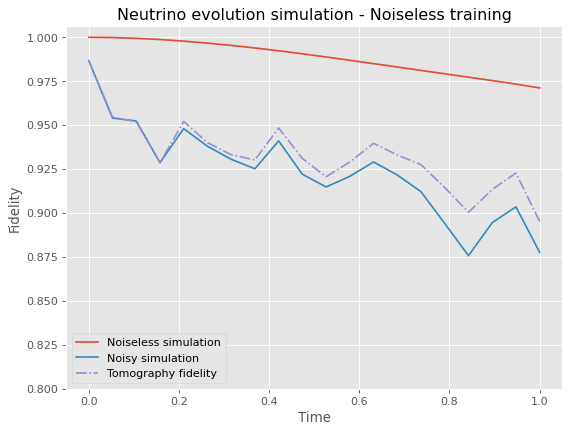

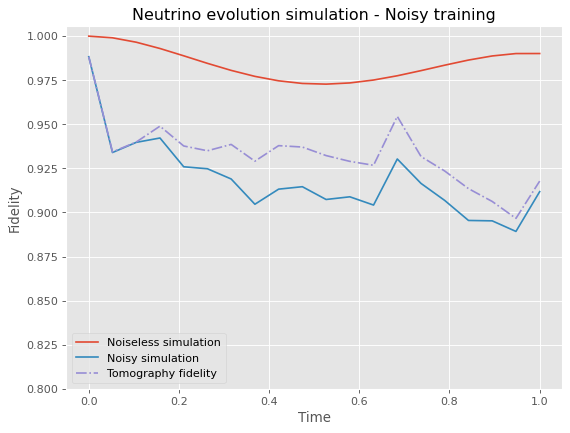

In [13]:
plot(ts,nless_train_nless_sim, nless_train_nsy_sim, nless_train_tomo_fid, 0.8, "Neutrino evolution simulation - Noiseless training")
plot(ts,nsy_train_nless_sim, nsy_train_nsy_sim, nsy_train_tomo_fid, 0.8, "Neutrino evolution simulation - Noisy training")

<div id='exp2'/>

# Experiment 2: Three qubits, two layers
We train the circuit based on fidelity in four time marks $t \in \{0.5,1.0,1.5,2.0\}$. The time interval for simulation is set to $[0,2]$, 

In [14]:
varform, time_param = circuit(num_qubits=3, num_layers=2)
print("Number of learnable parameters: ", varform.num_parameters-1)
print(varform.parameters[:-1])

Number of learnable parameters:  12
[ParameterVectorElement(alpha[0]), ParameterVectorElement(alpha[1]), ParameterVectorElement(beta[0]), ParameterVectorElement(beta[1]), ParameterVectorElement(delta[0]), ParameterVectorElement(delta[1]), ParameterVectorElement(eps[0]), ParameterVectorElement(eps[1]), ParameterVectorElement(gamma[0]), ParameterVectorElement(gamma[1]), ParameterVectorElement(kappa[0]), ParameterVectorElement(kappa[1])]


In [50]:
# param_opt_noiseless, value_opt_noiseless = optimize_simulation(varform, time_param, 4, time_max=2, noisy_backend=False)
# param_opt_noisy, value_opt_noisy = optimize_simulation(varform, time_param, 4, time_max=2, noisy_backend=True)

# pd.DataFrame(param_opt_noiseless).to_csv("opt_3q_2l_noiseless.csv", header=None, index=None)
# pd.DataFrame(param_opt_noisy).to_csv("opt_3q_2l_noisy.csv", header=None, index=None)

In [15]:
param_opt_noiseless = pd.read_csv("opt_3q_2l_noiseless.csv", header=None).to_numpy().flatten()
param_opt_noisy = pd.read_csv("opt_3q_2l_noisy.csv", header=None).to_numpy().flatten()

In [16]:
ts = np.linspace(0,2,20)
nless_train_nless_sim, nless_train_nsy_sim, nless_train_tomo_fid = simulation(varform, param_opt_noiseless, ts)
nsy_train_nless_sim, nsy_train_nsy_sim, nsy_train_tomo_fid = simulation(varform, param_opt_noisy, ts)

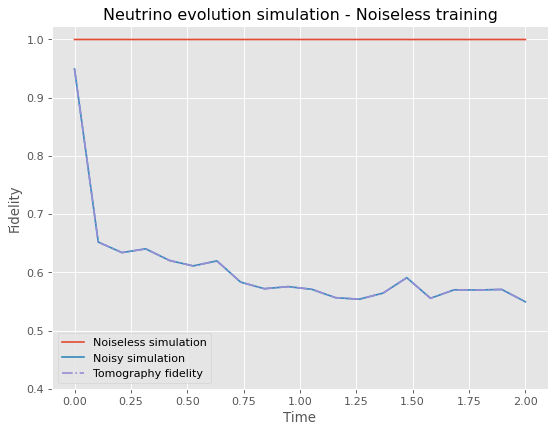

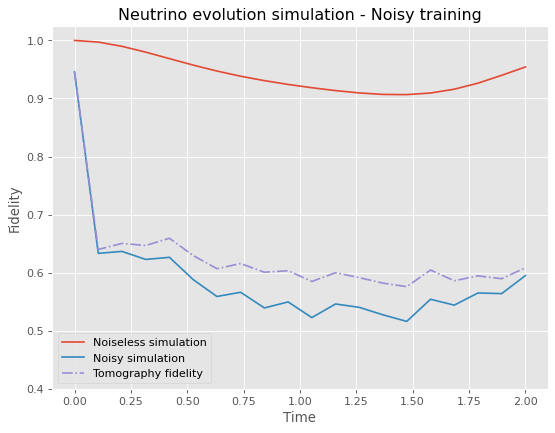

In [17]:
plot(ts,nless_train_nless_sim, nless_train_nsy_sim, nless_train_tomo_fid, 0.4, "Neutrino evolution simulation - Noiseless training")
plot(ts,nsy_train_nless_sim, nsy_train_nsy_sim, nsy_train_tomo_fid, 0.4, "Neutrino evolution simulation - Noisy training")

<div id='exp3'/>

# Experiment 3: Generalization
We show that getting the model to learn the optimal parameters for a few time marks suffices. In particular, we let it optimize the average fidelity at $2S$ time marks $t \in \{0.5,1.0,\dots,S-0.5,S\}$ in the time interval $[0,S]$.
The optimized model can simulate the exact time evolution over the entire period with high precision.

In [18]:
varform, time_param = circuit(num_qubits=4, num_layers=4)
print("Number of learnable parameters: ", varform.num_parameters-1)
print(varform.parameters[:-1])

Number of learnable parameters:  24
[ParameterVectorElement(alpha[0]), ParameterVectorElement(alpha[1]), ParameterVectorElement(alpha[2]), ParameterVectorElement(alpha[3]), ParameterVectorElement(beta[0]), ParameterVectorElement(beta[1]), ParameterVectorElement(beta[2]), ParameterVectorElement(beta[3]), ParameterVectorElement(delta[0]), ParameterVectorElement(delta[1]), ParameterVectorElement(delta[2]), ParameterVectorElement(delta[3]), ParameterVectorElement(eps[0]), ParameterVectorElement(eps[1]), ParameterVectorElement(eps[2]), ParameterVectorElement(eps[3]), ParameterVectorElement(gamma[0]), ParameterVectorElement(gamma[1]), ParameterVectorElement(gamma[2]), ParameterVectorElement(gamma[3]), ParameterVectorElement(kappa[0]), ParameterVectorElement(kappa[1]), ParameterVectorElement(kappa[2]), ParameterVectorElement(kappa[3])]


In [109]:
# param_opt_noiseless, value_opt_noiseless = optimize_simulation(varform, time_param, 6, time_max=3., noisy_backend=False, verbose=True)
# pd.DataFrame(param_opt_noiseless).to_csv("opt_4q_4l_noiseless.csv", header=None, index=None)

In [19]:
param_opt_noiseless = pd.read_csv("opt_4q_4l_noiseless.csv", header=None).to_numpy().flatten() # avg fid = 0.9999949
ts = np.linspace(0,3.0,20)
nless_train_nless_sim, nless_train_nsy_sim, nless_train_tomo_fid = simulation(varform, param_opt_noiseless, ts)

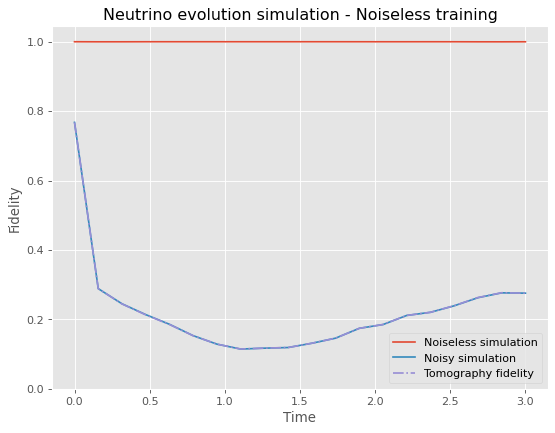

In [20]:
plot(ts,nless_train_nless_sim, nless_train_nsy_sim, nless_train_tomo_fid, 0., "Neutrino evolution simulation - Noiseless training")

<div id='exp4'/>

# Experiment 4: Model capacity
In this experiment, we investigate the variational form in its ability to approximate the exact time evolution over a long period. Only noiseless training is performed due to the time constraint of the hackathon.

We fix a configuration with $4$ qubits and $4$ layers. We want to find the longest time interval that the variational form still performs well. The number of time marks will be twice the length of the time interval, i.e. if the time interval is $[0,7]$, then there are 14 time marks $t \in \{0.5,1,\dots,6.5,7.0\}$.

In [26]:
varform, time_param = circuit(num_qubits=4, num_layers=4)
print("Number of learnable parameters: ", varform.num_parameters-1)
print(varform.parameters[:-1])

Number of learnable parameters:  24
[ParameterVectorElement(alpha[0]), ParameterVectorElement(alpha[1]), ParameterVectorElement(alpha[2]), ParameterVectorElement(alpha[3]), ParameterVectorElement(beta[0]), ParameterVectorElement(beta[1]), ParameterVectorElement(beta[2]), ParameterVectorElement(beta[3]), ParameterVectorElement(delta[0]), ParameterVectorElement(delta[1]), ParameterVectorElement(delta[2]), ParameterVectorElement(delta[3]), ParameterVectorElement(eps[0]), ParameterVectorElement(eps[1]), ParameterVectorElement(eps[2]), ParameterVectorElement(eps[3]), ParameterVectorElement(gamma[0]), ParameterVectorElement(gamma[1]), ParameterVectorElement(gamma[2]), ParameterVectorElement(gamma[3]), ParameterVectorElement(kappa[0]), ParameterVectorElement(kappa[1]), ParameterVectorElement(kappa[2]), ParameterVectorElement(kappa[3])]


In [27]:
# max_time_length = 6
# param_opt_list = []
# value_opt_list = []
# for n in range(1,max_time_length+1):
#     print(f'Time interval length = {n}, Num. time marks = {2*n}')
    
#     best_param_opt = 0
#     best_value_opt = 0
#     for _ in range(3):
#         param_opt_noiseless, value_opt_noiseless = optimize_simulation(varform, time_param, 2*n, time_max=n, noisy_backend=False)
#         if value_opt_noiseless < best_value_opt:
#             best_value_opt = value_opt_noiseless
#             best_param_opt = param_opt_noiseless
#     param_opt_list.append(best_param_opt)
#     value_opt_list.append(best_value_opt)
#     pd.DataFrame(np.array(value_opt_list)).to_csv("opt_val_time_length.csv", header=None, index=None)

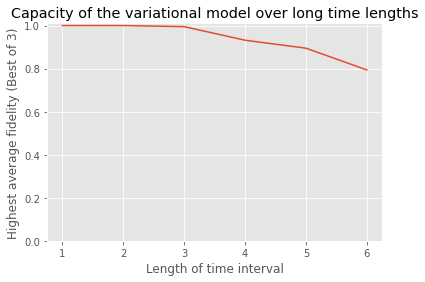

In [28]:
value_opt_list = pd.read_csv("opt_val_time_length.csv", header=None).to_numpy().flatten()


plt.plot(list(range(1,len(value_opt_list)+1)), -np.around(value_opt_list,decimals=3))
plt.xlabel('Length of time interval')
plt.ylabel('Highest average fidelity (Best of 3)')
plt.ylim(0)
plt.title("Capacity of the variational model over long time lengths")
plt.show()
